In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')
from pyspark.sql.functions import col

import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row

# enable repl.eagearEval
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
pip install --upgrade regex

Note: you may need to restart the kernel to use updated packages.


In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the Data

In [5]:
# read the data
tweets_by_account_type = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/sshende/tweets_by_account')

In [6]:
print("Number of rows:", tweets_by_account_type.count())
print("Number of columns:", len(tweets_by_account_type.columns))

Number of rows: 16531309
Number of columns: 2


In [7]:
tweets_by_account_type.limit(5)

account_type,text
Other,Watched high scho...
Other,@robbysoave The n...
Other,I never go to sch...
Other,“Do you mind if I...
Other,@JSS98Rock Red Ba...


In [8]:
tweets_by_account_type.groupBy('account_type').count()

account_type,count
Government Entities,111359
Other,16151242
Non-Profit Organi...,5892
Health Organizations,4068
News Outlets,193952
Social Media Infl...,2417
Education Organiz...,62379


To perform similarity Analysis, we will perform the following steps:
    
    1. Clean the data, remove stopwords and create index
    2. Fit countVectorizre to create word features
    3. Fit MinHashLSH to create hash table
    4. Establish similarity threshold and return near-duplicate records
    
    
To compare the unique and duplicate tweets we are using jaccard similarity.

*Jaccard Similarity* measures the similarity between two sets. It is calculated as the size of intersection divided by the size of the union of the two sets.

*Jaccard Similarity Threshold* is a measure of the similarity between two sets of data. The index ranges from 0 to 1. 
The closer to 1, the more similar the two sets of data. If two datasets share the exact same members, their Jaccard Similarity Index will be 1.

Hence, for analyzing similaarity of tweets by account_type, we will use the threshold = 0.7.
    

In [9]:
def similarityAnalysis(df, jaccard_distance):
    
    # remove null text values
    text = df.rdd.map(lambda x: x['text']).filter(lambda x: x is not None)

    # load english stopwords
    StopWords = stopwords.words("english")

    tokens = text\
        .map(lambda document: document.strip().lower())\
        .map(lambda document: re.split(" ", document))\
        .map(lambda word: [x for x in word if x.isalnum()])\
        .map(lambda word: [x for x in word if len(x) > 1])\
        .map(lambda word: [x for x in word if x not in StopWords])\
        .zipWithIndex()

    
    # assign a unique index to each document
    df_text = text.map(Row('text')).zipWithIndex().toDF(['text', 'id'])
    
    # convert to spark dataframe
    df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

    # Drop records with null values in list_of_words column
    df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
    
    vectorize = CountVectorizer(inputCol = 'list_of_words', outputCol = 'features', minDF = 1.0)
    df_vectorize = vectorize.fit(df_tokens). transform(df_tokens) 
    
    #fit MinHashLSH to create hash table
    mh = MinHashLSH(inputCol = 'features', outputCol = "hashes", numHashTables = 5)
    model = mh.fit(df_vectorize)
    df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()
    
    # join df_text with df_hashed on id column
    df_hashed = df_text.join(df_hashed, 'id', how = 'left').cache()
    
    df_dups = model.approxSimilarityJoin(df_hashed, df_hashed, jaccard_distance).filter('datasetA.id < datasetB.id').select(
            col('distCol'),
            col('datasetA.id').alias('id_A'),
            col('datasetB.id').alias('id_B'))
            #col('datasetA.text').alias('text_A'),
            #col('datasetB.text').alias('text_B'))
    
    df_dups.cache()
    
    # computer total records, unique records and near-duplicate records
    records = df_hashed.count()
    dups = df_dups.select('id_A').distinct().count()
    uniques = records - dups
    
    # remove all the blocks of df from memory and disk
    df_hashed.unpersist()
    df_dups.unpersist()
      
    return uniques, dups

In [10]:
influ_df = tweets_by_account_type.select('text').filter(col('account_type') == 'Social Media Influencers')
print(influ_df.count())
influ_df.limit(5)

2417


text
Mark your 📆! Th...
Now that’s colleg...
50 yard field goa...
@Balkroth @markha...
How is a universi...


Similarity Analysis on Influencers data

In [11]:
uniques, dups = similarityAnalysis(influ_df, 0.3)

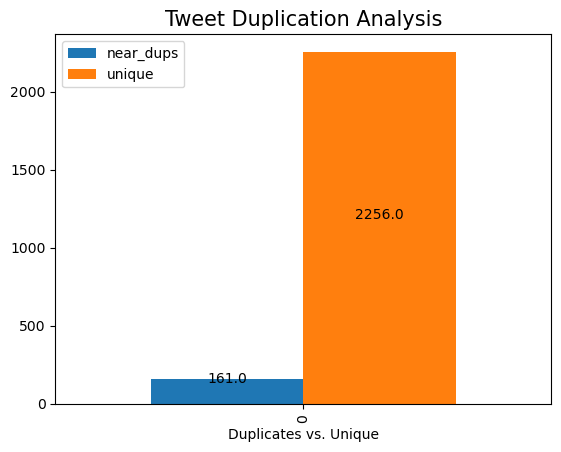

In [12]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
     ax.annotate(format(p.get_height(), '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                 ha = 'center', va = 'center', 
                 xytext = (0, 9), 
                 textcoords = 'offset points') 
plt.show()

Similarity analysis on Health Organizations

In [13]:
health_df = tweets_by_account_type.select('text').filter(col('account_type') == 'Health Organizations')
print(health_df.count())
health_df.limit(5)

4068


text
The world remembe...
NEW: Leading an e...
Don't let your ch...
Francesca Varallo...
It was a pleasure...


In [14]:
records, dups = similarityAnalysis(health_df, 0.3)

Total tweets:  3835
Duplicate tweets : 233
Unique tweets 3602


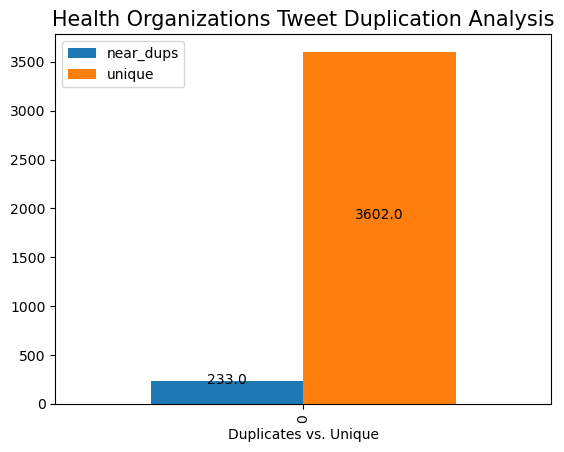

In [15]:
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets :', dups)
print ('Unique tweets', uniques)

dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Health Organizations Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

Similarity analysis on Non-Profit Organizations

In [16]:
ngo_df = tweets_by_account_type.select('text').filter(col('account_type') == 'Non-Profit Organizations')
print(ngo_df.count())
ngo_df.limit(5)

5892


text
He added that app...
Residents have re...
Wow you gotta lov...
This #FSUvsLSU ga...
What an incredibl...


In [17]:
records, dups = similarityAnalysis(ngo_df, 0.3)

Total tweets:  5565
Duplicate tweets : 327
Unique tweets 5238


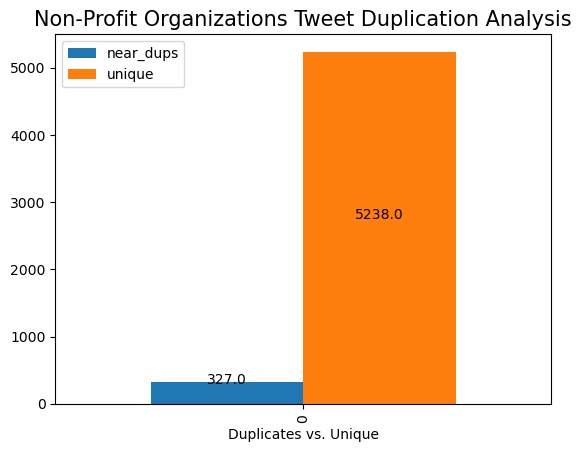

In [18]:
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets :', dups)
print ('Unique tweets', uniques)

dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Non-Profit Organizations Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

Similarity analysis on Education Organizations

In [19]:
edu_df = tweets_by_account_type.select('text').filter(col('account_type') == 'Education Organizations')
print(edu_df.count())
edu_df.limit(5)

62379


text
👓 Find the right...
Thanks to the bri...
@DrayTorpey1 We ?...
Morgan County Sch...
5 benefits of hav...


Since, the records are more than 10K we'll ramdonly samply approx 10k data and then perform similarity analysis on them

In [20]:
edu_sampled_data = edu_df.sample(0.15, seed = 43)

# Check the number of rows in the sampled data
edu_sampled_data.count()

9286

In [21]:
records, dups = similarityAnalysis(edu_sampled_data, 0.3)

Total tweets:  8469
Duplicate tweets : 817
Unique tweets 7652


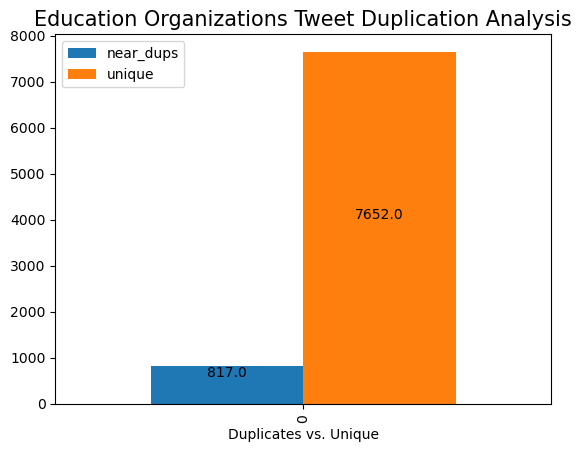

In [22]:
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets :', dups)
print ('Unique tweets', uniques)

dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Education Organizations Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

Similarity analysis on Government Entities

In [23]:
gov_df = tweets_by_account_type.select('text').filter(col('account_type') == 'Government Entities')
print(gov_df.count())
gov_df.limit(5)

111359


text
Our guy @MichaelC...
Find the perfect ...
@TXCryptoGuy80 Yo...
Unlike Kim Reynol...
No college studen...


In [24]:
gov_sampled_data = gov_df.sample(0.085, seed = 43)

# Check the number of rows in the sampled data
gov_sampled_data.count()

9396

In [25]:
records, dups = similarityAnalysis(gov_sampled_data, 0.3)

Total tweets:  9252
Duplicate tweets : 144
Unique tweets 9108


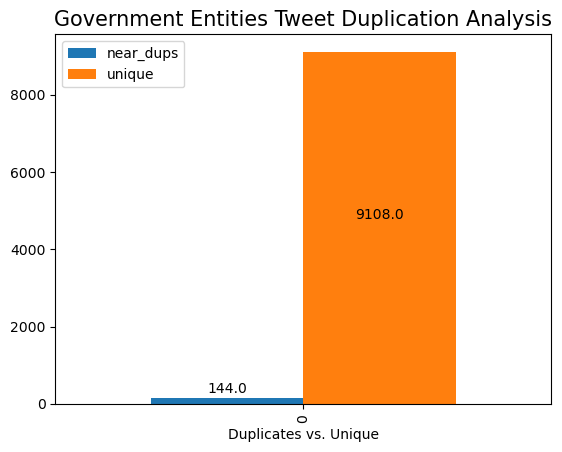

In [26]:
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets :', dups)
print ('Unique tweets', uniques)

dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Government Entities Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

Similarity Analysis on News Outlets

In [27]:
news_df = tweets_by_account_type.select('text').filter(col('account_type') == 'News Outlets')
print(news_df.count())
news_df.limit(5)

193952


text
This just makes m...
Outpouring of sup...
Here’s this week’...
Students at St. F...
'My daughter is b...


In [28]:
news_sampled_data = news_df.sample(0.05, seed = 43)

# Check the number of rows in the sampled data
news_sampled_data.count()

9600

In [29]:
records, dups = similarityAnalysis(news_sampled_data, 0.3)

Total tweets:  9348
Duplicate tweets : 252
Unique tweets 9096


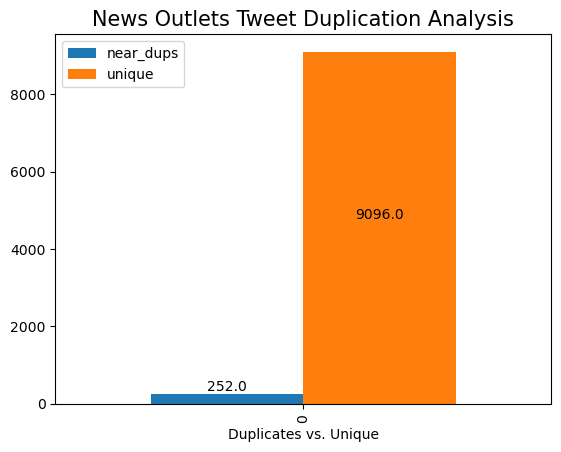

In [30]:
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets :', dups)
print ('Unique tweets', uniques)

dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News Outlets Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

Similarity Analysis on Other Twitterers

In [31]:
other_df = tweets_by_account_type.select('text').filter(col('account_type') == 'Other')
print(other_df.count())
other_df.limit(5)

16151242


text
Watched high scho...
@robbysoave The n...
I never go to sch...
“Do you mind if I...
@JSS98Rock Red Ba...


In [32]:
other_sampled_data = other_df.sample(0.00065, seed = 43)

# Check the number of rows in the sampled data
other_sampled_data.count()

10425

In [33]:
records, dups = similarityAnalysis(other_sampled_data, 0.3)

Total tweets:  10177
Duplicate tweets : 248
Unique tweets 9929


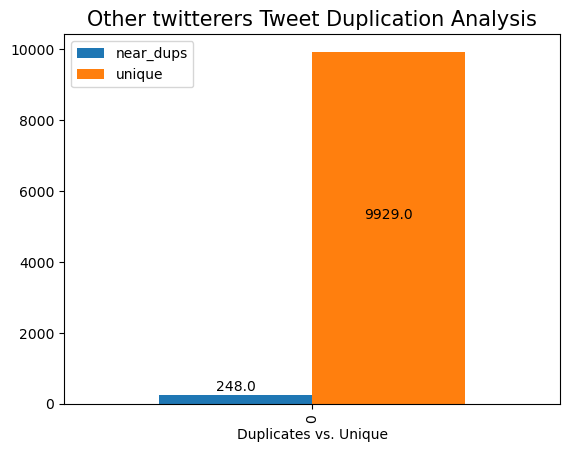

In [34]:
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets :', dups)
print ('Unique tweets', uniques)

dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Other twitterers Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 